In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
import pandas as pd
import transformers
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
#List of all NDA's in the dataset. 
kes=['nda-11', 'nda-16', 'nda-15', 'nda-10', 'nda-2', 'nda-1', 'nda-19', 'nda-12', 'nda-20', 'nda-3', 'nda-18', 'nda-7', 'nda-17', 'nda-8', 'nda-13', 'nda-5', 'nda-4']

#method to load json file
def get_json(path):  
  #################
  # Opening JSON file
  f = open(path)  
  # returns JSON object as 
  # a dictionary
  data = json.load(f)
  f.close()
  return data

#clean text
def preprocess(sentence):
  sentence=str(sentence)
  sentence = re.sub(r'[^A-Za-z0-9]+', ' ', sentence) 
  sentence = re.sub(r'https?:/\/\S+', ' ', sentence) 
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_url)  
  return " ".join(tokens)

In [4]:
# Do Not delete
def get_data(data, idx,ke):
  dataM=[]
  #Document level
  docid = data['documents'][idx]['id']
  
  string = data['documents'][idx]['text']
  file_name = data['documents'][idx]['file_name']
  spans = data['documents'][idx]['spans']
  spanall=[]
  for span in spans:           
      spanval = string[span[0]: span[1]]
      spanall.append(spanval)
  
  ndas = data['documents'][idx]['annotation_sets'][0]['annotations'] 
  # Keys level
    
  hypothesis = data['labels'][ke]['hypothesis']  

  # Key level   

  choice =ndas[ke] ['choice']
  spansC = ndas[ke] ['spans']    
  for si in range(len(spanall)):
    span_nbr =si
    if si in spansC:
      val=choice
    else:
      val="Neutral"
    premise = spanall[si]
    itm = [docid, file_name , ke, hypothesis, span_nbr, premise,val ]
    dataM.append(itm)
  df = pd.DataFrame(dataM ,columns = ['docid', 'file_name', 'hypotheis_key', 'hypotheis', 'span_nbr', 'premise', 'choice'   ])
  #"[CLS] " and " [SEP] "" [SEP]" 
  df['premise'] = df['premise'].apply(preprocess)
  df['hypotheis']= df['hypotheis'].apply(preprocess) 
  df['label'] = df['choice'].map(lambda s: 0 if s=='Entailment' else (1 if s== 'Contradiction' else 2 ))
  df['entl'] =  df['choice'].map(lambda s : 1 if s== 'Entailment' else 0)
  df['cont'] =  df['choice'].map(lambda s : 1 if s== 'Contradiction' else 0)
  df['neut'] =  df['choice'].map(lambda s : 1 if s== 'Neutral' else 0)
  df['bert_sent']= df.apply(lambda s: [s.premise,s.hypotheis], axis=1)
  return df

In [5]:

def create_documents_df(data, kes):
  df = pd.DataFrame([], columns=['docid','file_name','hypotheis_key','hypotheis','span_nbr','premise','choice','label','entl',	'cont','neut','bert_sent'])
  for idx in range(len(data['documents'])):
    for ke in kes:
      ad = get_data(data, idx, ke)
      df = df.append(ad)
  
  return df[["hypotheis","premise","choice"]]

In [6]:
data = get_json('/content/train.json')
dataT = get_json('/content/test.json')

df_train = create_documents_df(data, kes)
df_test = create_documents_df(dataT, kes)

[Text(0.5, 0, 'Labels')]

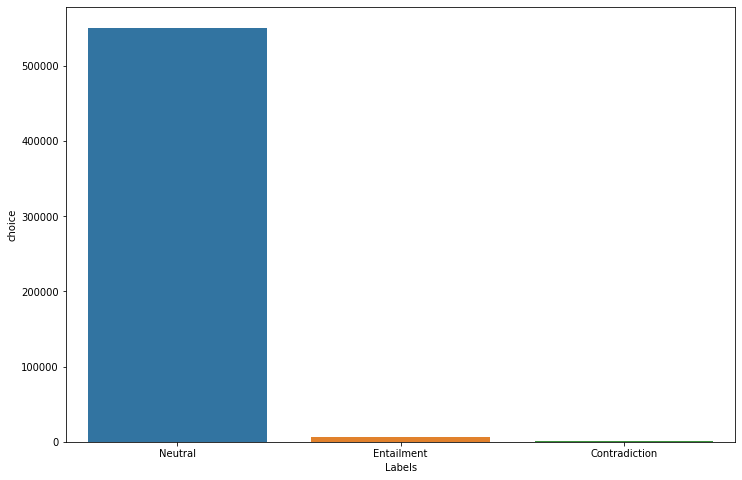

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
 
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=df_train.choice.unique(), y=df_train.choice.value_counts())

ax.set(xlabel='Labels')

In [8]:
df_train.head()

,hypotheis,premise,choice
0,Receiving Party shall not reverse engineer any...,NON DISCLOSURE AND CONFIDENTIALITY AGREEMENT,Neutral
1,Receiving Party shall not reverse engineer any...,This NON DISCLOSURE AND CONFIDENTIALITY AGREEM...,Neutral
2,Receiving Party shall not reverse engineer any...,i the Office of the United Nations High Commis...,Neutral
3,Receiving Party shall not reverse engineer any...,ii a company established in accordance with th...,Neutral
4,Receiving Party shall not reverse engineer any...,and having its principal offices located at,Neutral


In [9]:
df_train[df_train["premise"] != ""]

,hypotheis,premise,choice
0,Receiving Party shall not reverse engineer any...,NON DISCLOSURE AND CONFIDENTIALITY AGREEMENT,Neutral
1,Receiving Party shall not reverse engineer any...,This NON DISCLOSURE AND CONFIDENTIALITY AGREEM...,Neutral
2,Receiving Party shall not reverse engineer any...,i the Office of the United Nations High Commis...,Neutral
3,Receiving Party shall not reverse engineer any...,ii a company established in accordance with th...,Neutral
4,Receiving Party shall not reverse engineer any...,and having its principal offices located at,Neutral
...,...,...,...
124,Receiving Party shall not use any Confidential...,By s Timothy C Dolan,Neutral
125,Receiving Party shall not use any Confidential...,Title CEO Title V P Business Development,Neutral
126,Receiving Party shall not use any Confidential...,Address 575 Chesapeake Dr Address Lilly Corpor...,Neutral
128,Receiving Party shall not use any Confidential...,Redwood City CA 94063,Neutral


In [10]:
df_train[df_train["hypotheis"] != ""]

,hypotheis,premise,choice
0,Receiving Party shall not reverse engineer any...,NON DISCLOSURE AND CONFIDENTIALITY AGREEMENT,Neutral
1,Receiving Party shall not reverse engineer any...,This NON DISCLOSURE AND CONFIDENTIALITY AGREEM...,Neutral
2,Receiving Party shall not reverse engineer any...,i the Office of the United Nations High Commis...,Neutral
3,Receiving Party shall not reverse engineer any...,ii a company established in accordance with th...,Neutral
4,Receiving Party shall not reverse engineer any...,and having its principal offices located at,Neutral
...,...,...,...
125,Receiving Party shall not use any Confidential...,Title CEO Title V P Business Development,Neutral
126,Receiving Party shall not use any Confidential...,Address 575 Chesapeake Dr Address Lilly Corpor...,Neutral
127,Receiving Party shall not use any Confidential...,,Neutral
128,Receiving Party shall not use any Confidential...,Redwood City CA 94063,Neutral


In [12]:
df_train[df_train["choice"] != "Neutral"]

,hypotheis,premise,choice
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,Entailment
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,Entailment
38,Agreement shall not grant Receiving Party any ...,4 Nothing in this Agreement is to be construed...,Entailment
51,Receiving Party shall not disclose the fact th...,11 The Recipient shall not advertise or otherw...,Entailment
14,All Confidential Information shall be expressl...,1 Confidential Information whenever used in th...,Entailment
...,...,...,...
105,Receiving Party may share some Confidential In...,i a subsidiary or other affiliate of such Part...,Entailment
106,Receiving Party may share some Confidential In...,ii an officer director employee partner attorn...,Entailment
9,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,Entailment
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,Entailment


In [13]:
df_train[df_train["choice"] != "Neutral"]

,hypotheis,premise,choice
39,Receiving Party shall destroy or return some C...,5 All Confidential Information in any form and...,Entailment
40,Receiving Party shall destroy or return some C...,a if a business relationship is not entered in...,Entailment
38,Agreement shall not grant Receiving Party any ...,4 Nothing in this Agreement is to be construed...,Entailment
51,Receiving Party shall not disclose the fact th...,11 The Recipient shall not advertise or otherw...,Entailment
14,All Confidential Information shall be expressl...,1 Confidential Information whenever used in th...,Entailment
...,...,...,...
105,Receiving Party may share some Confidential In...,i a subsidiary or other affiliate of such Part...,Entailment
106,Receiving Party may share some Confidential In...,ii an officer director employee partner attorn...,Entailment
9,Receiving Party shall not use any Confidential...,Neither the Recipient nor any of the Recipient...,Entailment
10,Receiving Party shall not use any Confidential...,a make use of any of the Provider s Confidenti...,Entailment


In [16]:
df_train.to_csv(r'/content/train.csv', index=False)
df_test.to_csv(r'/content/test.csv', index=False)